In [1]:
import pickle
import gzip
import os
import time
import copy
import cv2
import random

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Visualisation Fuctions

In [4]:
def show_video(frames, masks, speed=0.0001):
    
    video = frames.copy()
    masked_video = video * masks  # Apply the mask to each frame
    
    num_frames = video.shape[2]
    plt.figure(figsize=(10, 5))
    
    for i in range(num_frames):
        plt.clf()  # Clear the previous plot
        
        # Left subplot: Original video
        plt.subplot(1, 2, 1)
        plt.imshow(video[:, :, i], cmap='gray')
        plt.axis('off')
        plt.title(f"Original Frame {i+1}/{num_frames}")
        
        # Right subplot: Masked video
        plt.subplot(1, 2, 2)
        plt.imshow(masked_video[:, :, i], cmap='gray')
        plt.axis('off')
        plt.title(f"Masked Frame {i+1}/{num_frames}")
        
        # Display and wait
        display(plt.gcf())
        clear_output(wait=True)
        time.sleep(speed)

## Load Data

In [7]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object
    
# load data
test_data = load_zipped_pickle("test.pkl")
train_data = load_zipped_pickle("train.pkl")

train_data_amateurs = []
train_data_experts = []
train_data_all = []

print("Dividing Data")
    
for item in tqdm(train_data):
    if(item['dataset'] == "amateur"):
        train_data_amateurs.append(item)
    else:
        train_data_experts.append(item)
    train_data_all.append(copy.deepcopy(item))
    
    
def eliminate_exes(data_point):  
    video = data_point['video'] 
    frames = data_point['frames'] 
    label = data_point['label']
    
    height, width, n_frames = video.shape
    
    cut_video = np.zeros((height, width, len(frames)))
    cut_label = np.zeros((height, width, len(frames)))
    
    for i, f in enumerate(frames):
        cut_video[:, :, i] = video[:, :, f]
        cut_label[:, :, i] = label[:, :, f]
        
    data_point['video'] = cut_video
    data_point['label'] = cut_label

def clean_data(data):
    for item in tqdm(data):
        eliminate_exes(item)
        
print("Removing Duds")
# one time run!!
clean_data(train_data_amateurs)
clean_data(train_data_experts)
clean_data(train_data_all)
print("Finished Loading Data\n")
print(f"Amateur Train set items:{len(train_data_amateurs)}")
print(f"Expert Train set items:{len(train_data_experts)}")
print(f"All Train set items:{len(train_data_all)}")

Dividing Data


100%|██████████| 65/65 [00:00<00:00, 136.87it/s]


Removing Duds


100%|██████████| 65/65 [00:00<00:00, 93.30it/s] 

Finished Loading Data

Amateur Train set items:46
Expert Train set items:19
All Train set items:65


## Visualize Training Data

In [ ]:
def print_data_item(dataset, index):
    frame = dataset[index]['video']
    box = dataset[index]['box']
    label = dataset[index]['label']
    l = frame.shape[2]
    
    #center_x, center_y = all_train_dataset.centers_data[index]
    #center_x, center_y = center_x.astype(int), center_y.astype(int)
    #box_f[center_x][center_y] = False
    
    for i in range(l):
        fig, axs = plt.subplots(1, 2, figsize=(6, 3))
        axs[0].imshow(frame[:,:,i], cmap='gray')
        #axs[1].imshow(box, cmap='gray')
        axs[1].imshow(label[:,:,i], cmap='gray')
        plt.tight_layout()
        plt.show()

data_set = train_data_experts
for index in range(len(data_set)):
    print_data_item(data_set, index)

## define Box Model

In [9]:
class BoxModel(nn.Module):
    def __init__(self):
        super(BoxModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, 2),  # Predicting 2 coordinates (x, y)
            nn.Sigmoid()  # Sigmoid for normalized coordinates [0, 1]
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x
    
box_model = torch.load("models/box_model.pth")

## Box Model Dataset

In [12]:
class BoxDataset(Dataset):
    def __init__(self, frames_data, boxes_data, labels_data, transform=None):
        self.frames_data = frames_data     
        self.boxes_data = boxes_data  
        self.labels_data = labels_data
        self.transform = transform

    def __getitem__(self, index):
        frame = self.frames_data[index]  # shape (height, width)
        box = self.boxes_data[index]
        label = self.labels_data[index]
        
        frame, box, label = self.transform(frame, box, label)
        
        center = extract_box_center(box)
            
        frame = torch.FloatTensor(frame)
        box = torch.FloatTensor(box)
        label = torch.FloatTensor(label)
        center = torch.FloatTensor(center)

        return frame, box, label, center

    def __len__(self):
        return len(self.frames_data)
    
class RandomRotation:
    def __init__(self, angle_range=(0, 360)):
        self.angle_range = angle_range

    def __call__(self, frame, box, label):
        angle = random.uniform(*self.angle_range) 
        height, width = frame.shape
        
        rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1.0)
        
        rotated_frame = cv2.warpAffine(frame, rotation_matrix, (width, height))
        rotated_label = cv2.warpAffine(label, rotation_matrix, (width, height))
        
        rotated_box = cv2.warpAffine(box.astype(np.uint8), rotation_matrix, (width, height), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
        rotated_box = rotated_box.astype(bool)
        
        return rotated_frame, rotated_box, rotated_label

In [14]:
def extract_box_center_batch(box_batch):
    l = box_batch.shape[0]
    
    center_batch = []
    
    for i in range(l):
        center_batch.append( extract_box_center(box_batch[i,:,:]))
    
    center_batch = np.array(center_batch)
    
    return torch.FloatTensor(center_batch)

def extract_box_center(box):
    # Find indices where the box is True
    true_indices = np.argwhere(box)
    
    # Get the min and max indices for rows and columns
    min_row, min_col = true_indices.min(axis=0)
    max_row, max_col = true_indices.max(axis=0)
    
    # Compute the center of the bounding box
    center_x = (min_row + max_row) // 2
    center_y = (min_col + max_col) // 2
    
    return np.array([center_x / 255.0, center_y / 255.0])

def resize_boolean_array(b_item, shape=(256, 256)):
    # Resize directly using nearest-neighbor interpolation
    resized_item = cv2.resize(
        b_item.astype(np.uint8), 
        (shape[1], shape[0]), 
        interpolation=cv2.INTER_NEAREST
    )
    
    # Convert back to boolean
    return resized_item.astype(bool)

In [71]:
def get_resized_list(data):
    f = []
    b = []
    l = []
    
    for item in tqdm(data):
        for i in range(item['video'].shape[2]):
            f_item = item['video'][:,:,i] 
            b_item = item['box']
            l_item = item['label'][:,:,i] 
            
            frame = cv2.resize(f_item.astype(np.uint8), (256, 256)) #/ 255.0
            f.append(frame)
            
            label = cv2.resize(l_item.astype(np.uint8), (256, 256)) #/ 255.0
            l.append(label)
 
            box = resize_boolean_array(b_item, shape=(256, 256))
            b.append(box)
 
    return f, b, l

#f_a, b_a, l_a = get_resized_list(train_data_amateurs)
#f_e, b_e, l_e = get_resized_list(train_data_experts)
f_ae, b_ae, l_ae = get_resized_list(train_data_all)

#box_amateur_train_dataset = BoxDataset(f_a, b_a, l_a, transform=RandomRotation())
#box_expert_train_dataset = BoxDataset(f_e, b_e, l_e, transform=RandomRotation())
box_all_train_dataset = BoxDataset(f_ae, b_ae, l_ae, transform=RandomRotation())

100%|██████████| 65/65 [00:00<00:00, 173.67it/s]


0.21568627655506134,0.5333333611488342
55,136


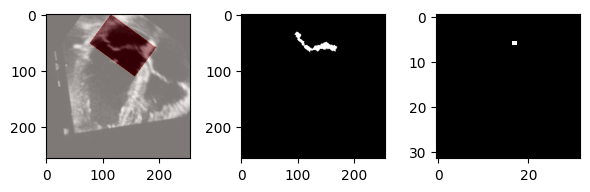

In [73]:
def print_BoxDataset_item(dataset, index):
    frame, box, label, center = dataset.__getitem__(index)
    
    x, y = center.detach().numpy()
    x1, y1 = (x * 255.0).astype(int), (y * 255.0).astype(int)
    print(f"{x},{y}")
    print(f"{x1},{y1}")
    abba = np.zeros((32,32), dtype=bool)
    abba[x1 // 8][y1 // 8] = True
    
    fig, ax = plt.subplots(1, 3, figsize=(6, 3))
    ax[0].imshow(frame, cmap='gray')
    ax[0].imshow(box, cmap='Reds', alpha=0.5) 
    ax[1].imshow(label, cmap='gray')
    ax[2].imshow(abba, cmap='gray')
    plt.tight_layout()
    plt.show()
        
print_BoxDataset_item(box_all_train_dataset, 0)

In [87]:
def train_model(train_loader, model, criterion, optimizer, num_epochs):
    model.train()
    losses = []
    for epoch in range(num_epochs):
        total_loss = 0
        for frame_batch, _, _, center_batch in train_loader: 
            
            frame_batch, center_batch = frame_batch.to(device), center_batch.to(device)
            optimizer.zero_grad()
            
            outputs = model(frame_batch.unsqueeze(1))
            
            loss = criterion(outputs, center_batch.float())
            loss.backward()
            
            optimizer.step()
            total_loss += loss.item()
        losses.append(total_loss/len(train_loader))
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")
        
    return losses
        
#box_amateur_train_loader = DataLoader(box_amateur_train_dataset, batch_size=32, shuffle=True)
#box_expert_train_loader = DataLoader(box_expert_train_dataset, batch_size=32, shuffle=True)
box_all_train_loader = DataLoader(box_all_train_dataset, batch_size=32, shuffle=True)

In [91]:
box_model = BoxModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(box_model.parameters(), lr=0.001)

losses_ae = train_model(box_all_train_loader, box_model, criterion, optimizer, num_epochs=70)

#print("Training on Amateur Data:\n")
#losses_a = train_model(box_amateur_train_loader, box_model, criterion, optimizer, num_epochs=30)

# Freeze convolutional layers
#for param in box_model.conv_layers.parameters():
#    param.requires_grad = False

# Unfreeze the final fully connected layers
#for param in box_model.fc_layers.parameters():
#    param.requires_grad = True

#optimizer = optim.Adam(box_model.fc_layers.parameters(), lr=0.0001)

#print("\nTraining on Expert Data:\n")
#losses_e = train_model(box_expert_train_loader, box_model, criterion, optimizer, num_epochs=30)


Epoch 1/70, Loss: 0.12102789884167058
Epoch 2/70, Loss: 0.05074621244732823
Epoch 3/70, Loss: 0.01891649647482804
Epoch 4/70, Loss: 0.011936471930571966
Epoch 5/70, Loss: 0.012158525575484549
Epoch 6/70, Loss: 0.010243348644248076
Epoch 7/70, Loss: 0.007769782628331866
Epoch 8/70, Loss: 0.007836506901574987
Epoch 9/70, Loss: 0.005822440077151571
Epoch 10/70, Loss: 0.0055948498858405015
Epoch 11/70, Loss: 0.0053391909625913414
Epoch 12/70, Loss: 0.0068227141829473635
Epoch 13/70, Loss: 0.005279098471094455
Epoch 14/70, Loss: 0.004824645285095487
Epoch 15/70, Loss: 0.004207616106473974
Epoch 16/70, Loss: 0.004659188944580299
Epoch 17/70, Loss: 0.004622235761157104
Epoch 18/70, Loss: 0.004176880000159144
Epoch 19/70, Loss: 0.004876738746783563
Epoch 20/70, Loss: 0.003464471415749618
Epoch 21/70, Loss: 0.003599841147661209
Epoch 22/70, Loss: 0.0032065048082066433
Epoch 23/70, Loss: 0.0037549233862331937
Epoch 24/70, Loss: 0.0038556944844978197
Epoch 25/70, Loss: 0.0035455869510769844
Epoch

In [99]:
torch.save(box_model, "models/box_model_final_0.pth")

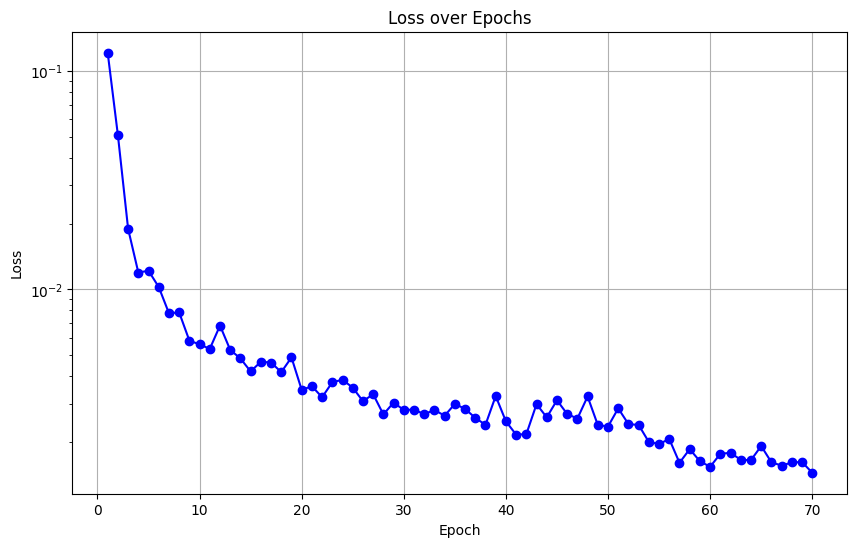

In [93]:
def plot_losses(losses):
    epochs = list(range(1, len(losses) + 1))
    plt.figure(figsize=(10, 6))
    plt.semilogy(epochs, losses, marker='o', linestyle='-', color='b')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
    
#plot_losses(losses_a)
#plot_losses(losses_e)
plot_losses(losses_ae)

### Box from Center Helper Function

In [56]:
def reconstruct_box_from_center_batch(center_batch):
    batch_size = center_batch.shape[0]
    box_batch = []

    
    for i in range(batch_size):
        center_x, center_y = center_batch[i,:].detach().cpu().numpy()
        center_x, center_y = (center_x*255.0).astype(int), (center_y*255.0).astype(int)
        #print(f"{center_x}, {center_y}")
        box_batch.append(reconstruct_box_from_center((center_x, center_y)))
    
    return torch.BoolTensor(np.array(box_batch))

def reconstruct_box_from_center(center, shape=(256,256), box_width=128, box_height=128):
    
    half_width = box_width // 2
    half_height = box_height // 2
    
    center_x, center_y = center
    
    box = np.zeros(shape, dtype=bool)
        
    # Calculate box boundaries
    x1 = max(0, center_x - half_width)
    x2 = min(shape[0] - 1, center_x + half_width)
    y1 = max(0, center_y - half_height)
    y2 = min(shape[1] - 1, center_y + half_height)

    box[x1:x2+1, y1:y2+1] = True
    
    return box
    

## Visualize Box model on Test Data

100%|██████████| 20/20 [05:23<00:00, 16.20s/it]


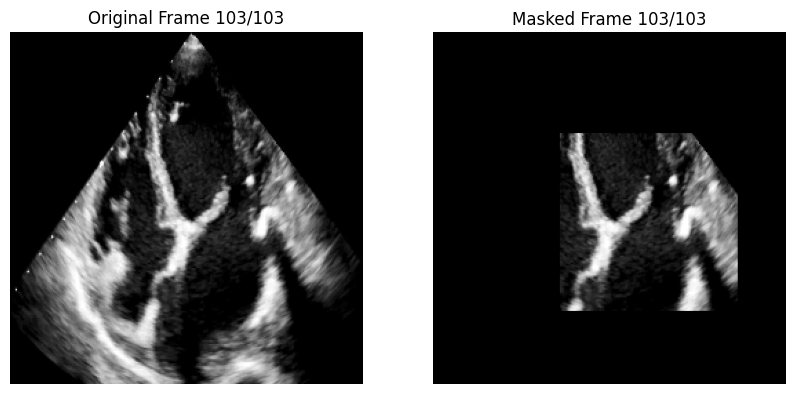

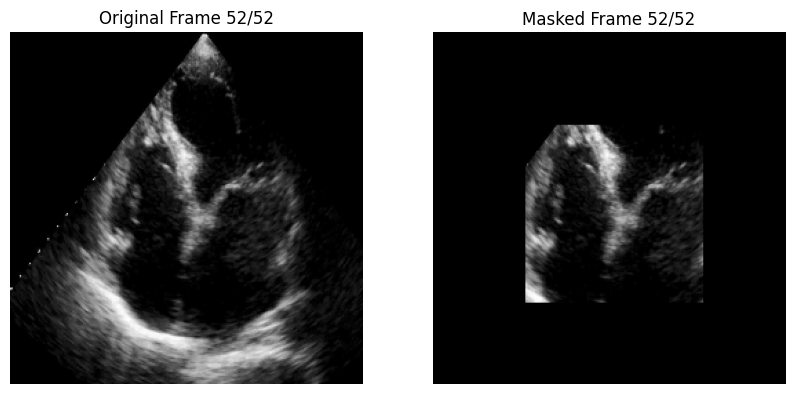

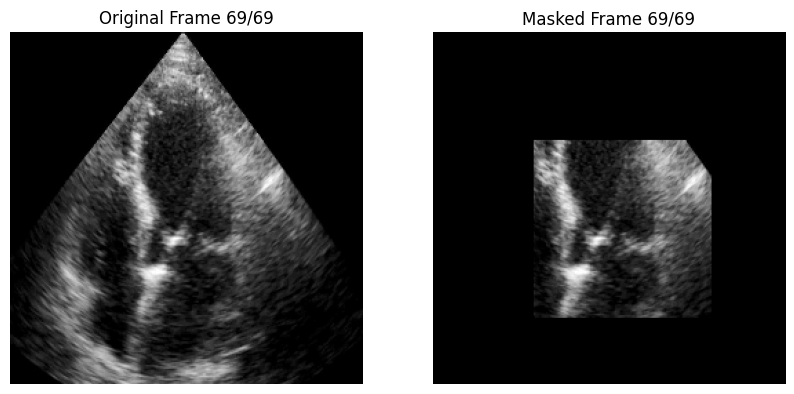

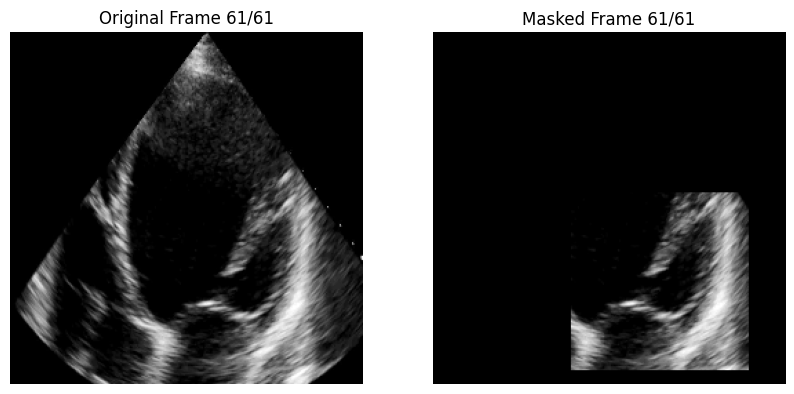

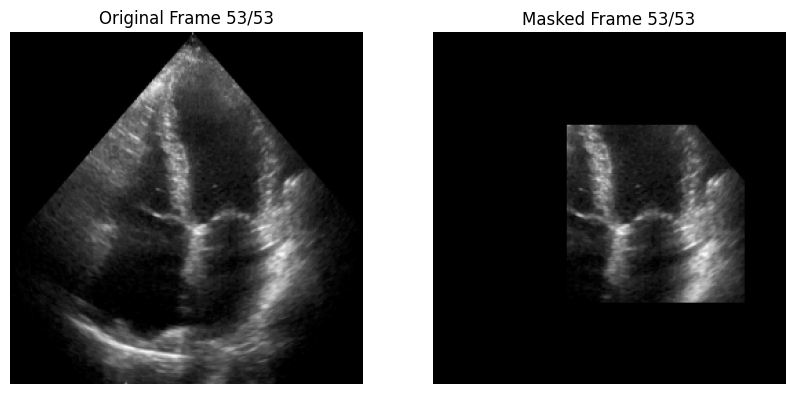

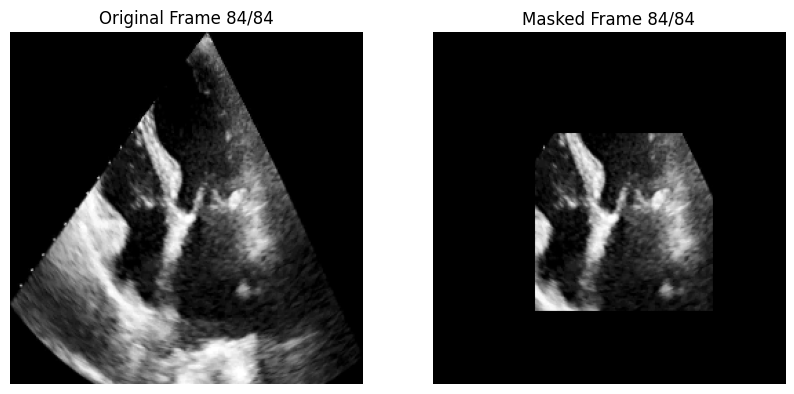

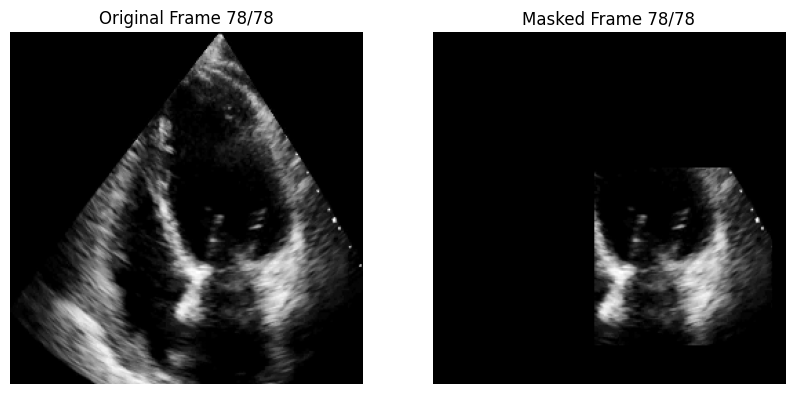

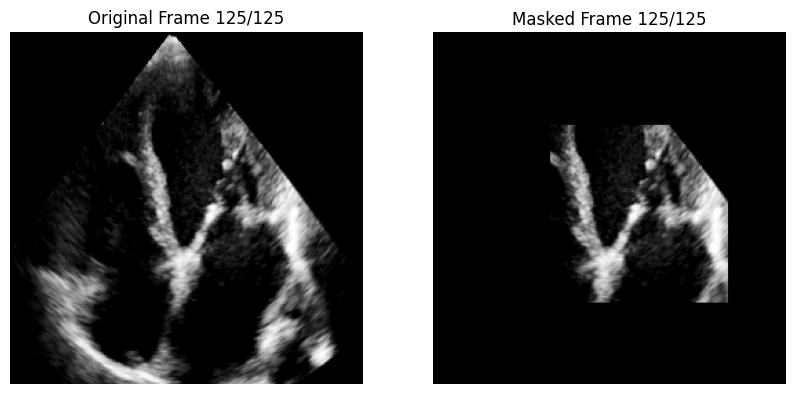

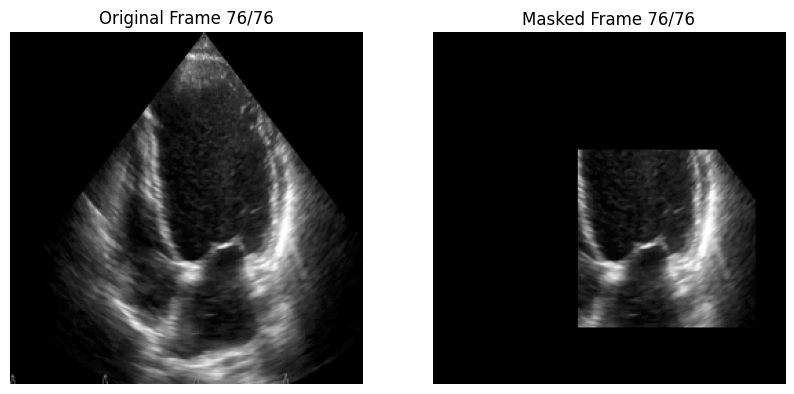

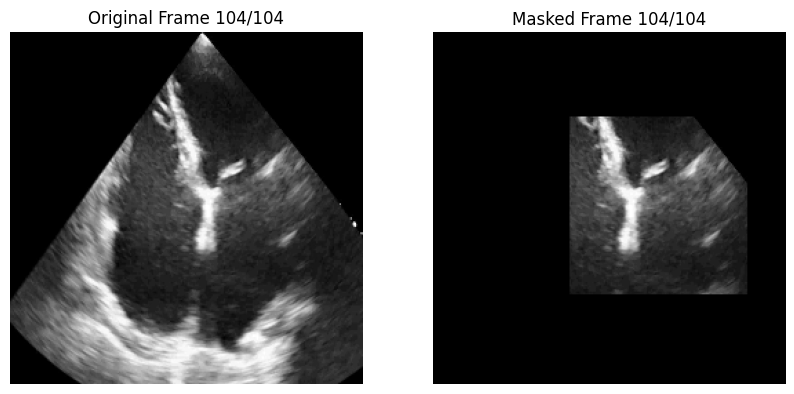

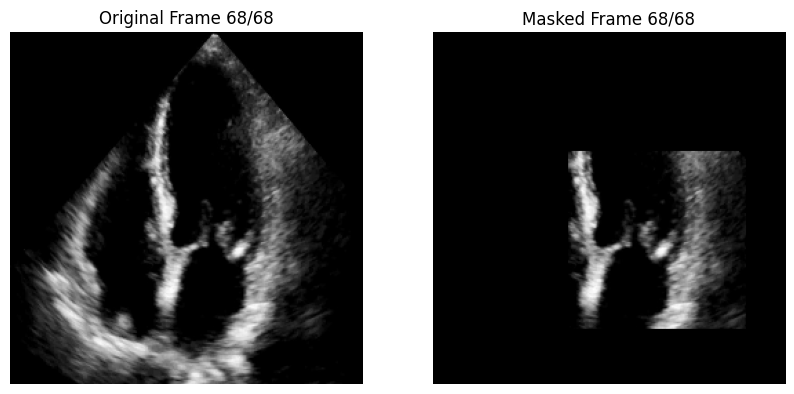

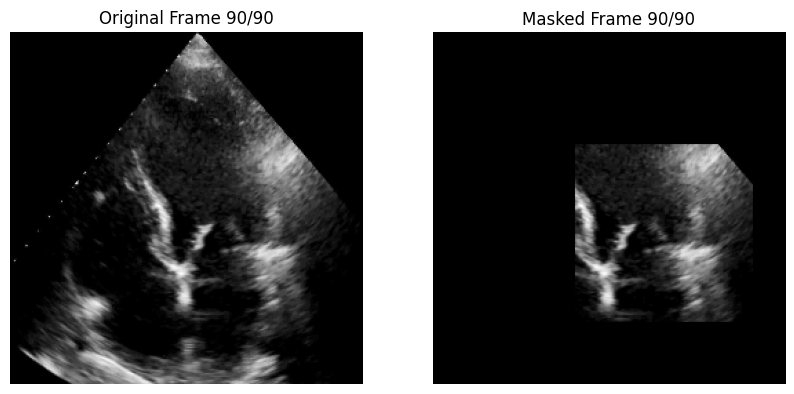

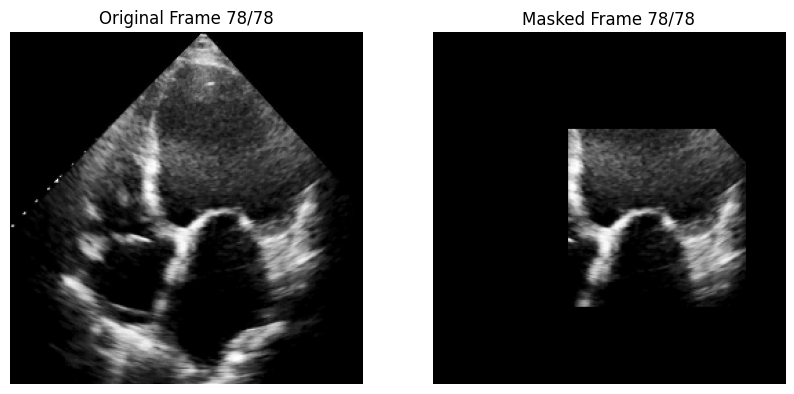

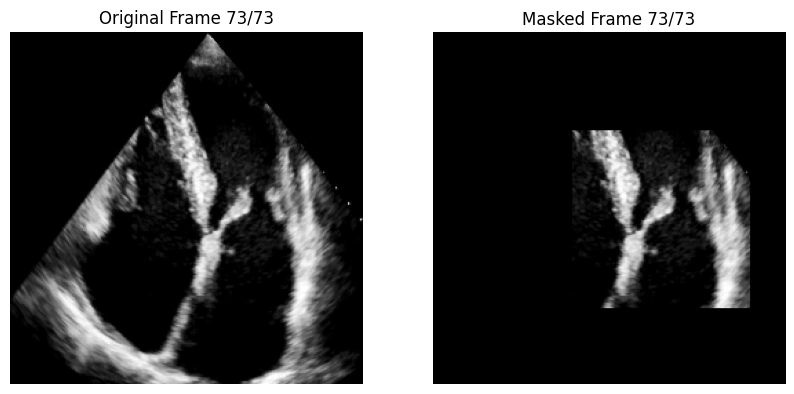

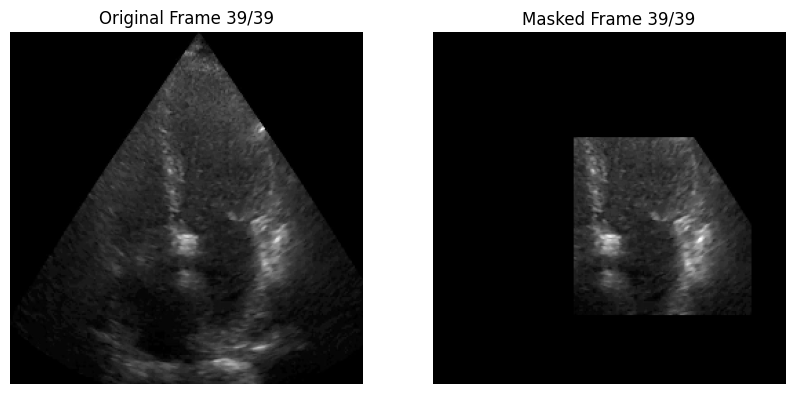

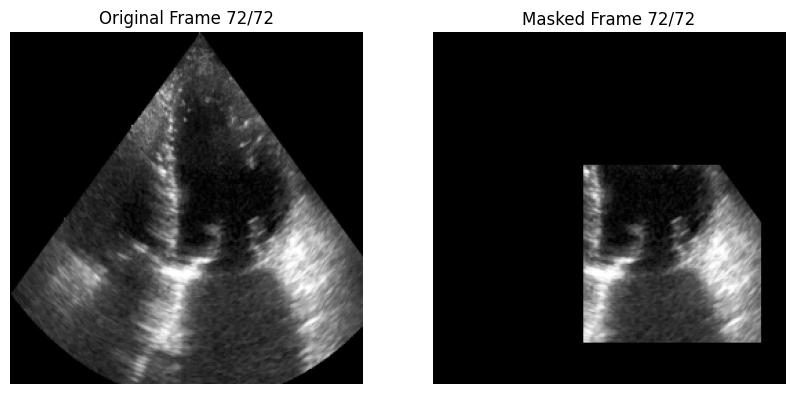

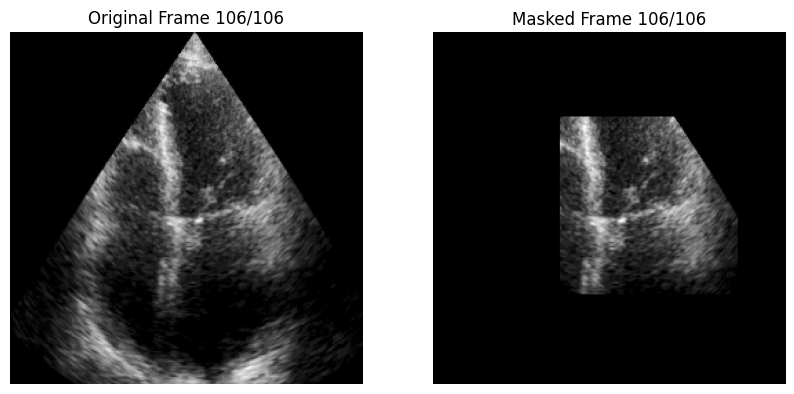

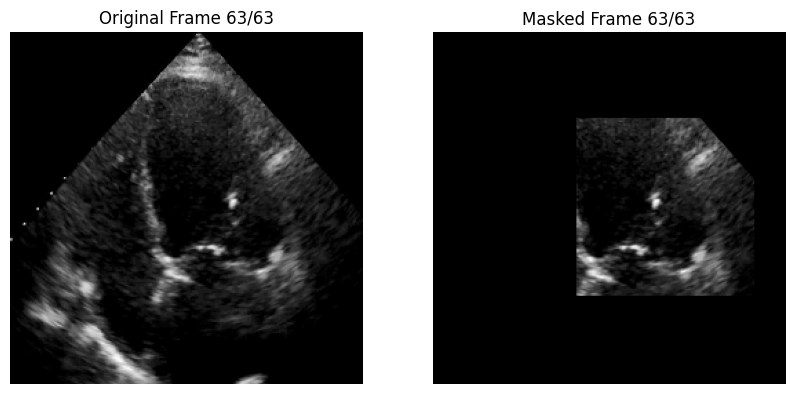

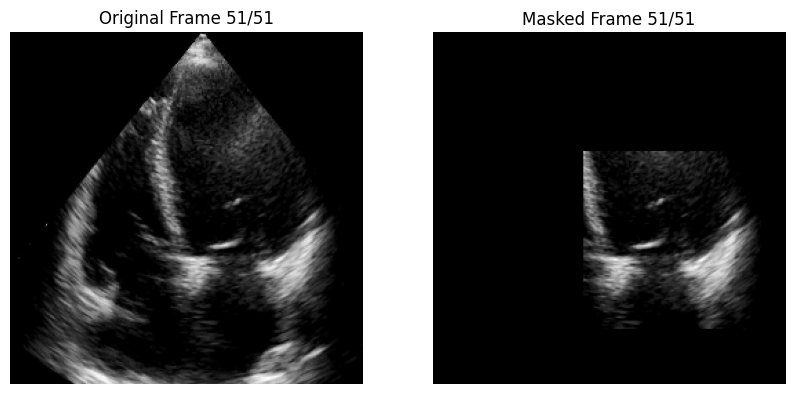

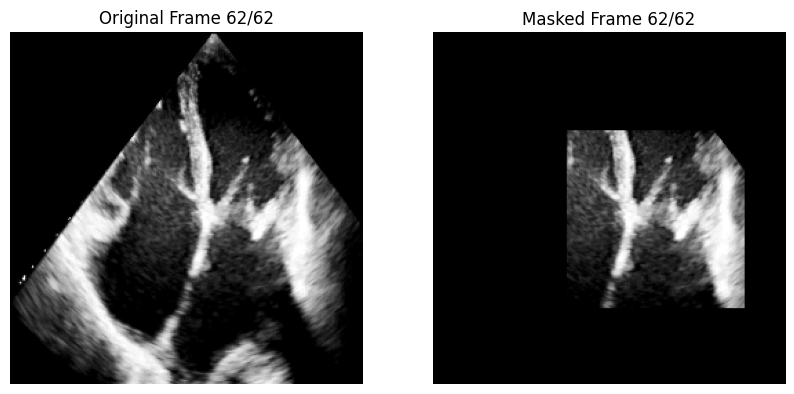

In [97]:
def test_box(data, model, index):
    test_video = data[index]['video']
    vid = np.zeros((256,256,test_video.shape[2]))
    for i in range(test_video.shape[2]):
        vid[:,:,i] = cv2.resize(test_video[:,:,i].astype(np.uint8), (256, 256))

    vid = torch.FloatTensor(vid)
    frames = vid.unsqueeze(0)
    frames = frames.permute(3, 0, 1, 2)

    model.to(device)
    model.eval()
    frame_box_coords = box_model(frames.to(device))
    boxes = reconstruct_box_from_center_batch(frame_box_coords)

    video_frames = frames.squeeze().permute(1, 2, 0)
    video_boxes = boxes.permute(1, 2, 0)

    show_video(frames=video_frames.detach().numpy(), masks=video_boxes.detach().numpy())

lili = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
for index in tqdm(lili):
    test_box(test_data, box_model, index)
    index += 1